# MB-PLS introduction example

This notebook intends to illustrate how to use Multiblock Partial Least Squares (MB-PLS) regression. To make things easier we are going to use a very simple simulated dataset with two $\textbf{X}$ blocks.

MB-PLS aims at establishing predictive models using latent variable spaces. In addition to PLS, it provides a measure on how much each $\textbf{X}$ block contributes to the actual prediction of the response $\textbf{Y}$.
 

## First, we initialize our data simulation by defining the parameters below.
Let's start without noise. Once you have run through this notebook just go ahead and increase the noise. It will give you a feeling for the influence of noise on the MBPLS estimation.

In [1]:
rand_seed = 25
num_samples = 20
num_vars_x1 = 25
num_vars_x2 = 45
noise = 0      # add noise between 0..10

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ortho_group

## Generate Loadings

In [3]:
np.random.seed(rand_seed)
p1 = np.expand_dims(np.random.randint(0, 10, num_vars_x1), 1)
p2 = np.expand_dims(np.sin(np.linspace(0, 5, num_vars_x2)), 1)

## Plot loadings
To generate some data we define two loading vectors, which we will utilize to generate data for $\textbf{X}_1$ and $\textbf{X}_2$, respectively. As you can see below these loading vectors have different characterstic shapes. Further down, we will refer to these lodings as the "ground truth". 

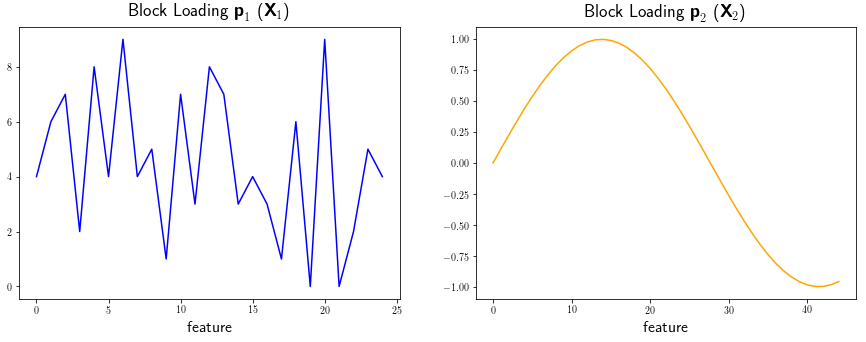

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(p1, color='blue')
ax[0].set_title(r'Block Loading $\textbf{p}_1$ ($\textbf{X}_1$)', fontsize=18)
ax[0].set_xlabel('feature', fontsize=16)
ax[1].plot(p2, color='orange')
ax[1].set_title(r'Block Loading $\textbf{p}_2$ ($\textbf{X}_2$)', fontsize=18)
ax[1].set_xlabel('feature', fontsize=16);

## Generate orthogonal scores
Here we generate some orthogonal scores. We impose orthogonality to make this analysis clear and simple. Of course, real data would typically deviate from this condition.

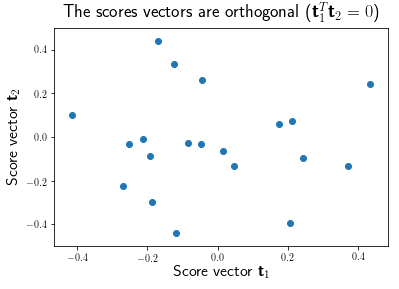

In [5]:
t = ortho_group.rvs(num_samples, random_state=rand_seed)[:, 0:2]
t1 = t[:,0:1]
t2 = t[:,1:2]

plt.figure()
plt.scatter(t1, t2)
plt.xlabel(r'Score vector $\textbf{t}_1$', size=16)
plt.ylabel(r'Score vector $\textbf{t}_2$', size=16)
plt.title(r'The scores vectors are orthogonal ($\textbf{t}_1^T\textbf{t}_2 = 0$)', fontsize=18);

## Generate data using loadings and scores
Two data blocks are generated. Block $\textbf{X}_1$ is formed as the outer vector product of loading vector $\textbf{p}_1$ and score vector $\textbf{t}_1$. Similarily, the data block $\textbf{X}_2$ is calculated as the outer vector product of loading vector $\textbf{p}_2$ and score vector $\textbf{t}_2$.

$\textbf{X}_1=\textbf{t}_1\cdot\textbf{p}_1^T$

$\textbf{X}_2=\textbf{t}_2\cdot\textbf{p}_2^T$

In [6]:
x1 = np.dot(t1, p1.T)
x2 = np.dot(t2, p2.T)

## Add noise to the data (according to noise parameter)
Here we add some noise to show how this impacts the analysis.

In [7]:
x1 = np.random.normal(x1, 0.05*noise)
x2 = np.random.normal(x2, 0.05*noise)

## Plot data blocks $\textbf{X}_1$ and $\textbf{X}_2$
Let's look at the data blocks $\textbf{X}_1$ and $\textbf{X}_2$. The variance in $\textbf{X}_1$ is related to the first score vector $\textbf{t}_1$ while the variance in $\textbf{X}_2$ is related to the second score vector $\textbf{t}_2$ 

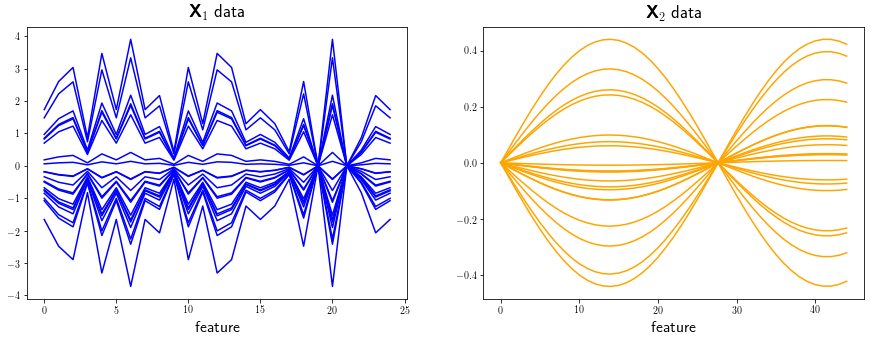

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(x1.T, color='blue') 
ax[0].set_title(r'$\textbf{X}_1$ data', fontsize=18) 
ax[0].set_xlabel('feature', size=16)
ax[1].plot(x2.T, color='orange') 
ax[1].set_title(r'$\textbf{X}_2$ data', fontsize=18) 
ax[1].set_xlabel('feature', size=16);

## Perform MB-PLS
We perform MB-PLS to simply fit the data. As a result we will obtain block loadings and scores, superscores and block importances. For further information on the algorithms please check out reference [1].

With this simple example we aim to find out about the following:

1. How much does each block contribute to the prediction of the score vectors $\textbf{t}_1$ and $\textbf{t}_2$ ($=\textbf{Y}$)? This measure we call block importance $a$.
2. What are the feature contributions in each block (block loadings $\hat{\textbf{p}}_1$ and $\hat{\textbf{p}}_2$)?
3. Are the fitted block scores $\hat{\textbf{t}}_1$ and $\hat{\textbf{t}}_2$ describing the ground truth of our chosen block scores $\textbf{t}_1$ and $\textbf{t}_2$?

In [9]:
from mbpls.mbpls import MBPLS
mbpls_model = MBPLS(n_components=2,method='UNIPALS',standardize=False)
mbpls_model.fit(X=[x1, x2], Y=t);

A 2 component model was fitted to the data. PLS maximizes co-variance between the $\textbf{t}_s$ and $\textbf{u}$ score vectors for each extracted latent variable. When such a projection (latent variable) is found it is used to deflate the explained variance on all data blocks in $\textbf{X}$. After that further latent variables (= components) can be extracted. 
In this example we are fitting the data $\textbf{X}_1$ and $\textbf{X}_2$ simulatenously to $\textbf{Y}$. As $\textbf{Y}$ contains our two known orthogonal score vectors we expect to require two latent variables (LV) to fit the data.

Usually we recommend to allways standardize the data blocks. This is important to give the blocks similar weight on the model, i.e. to correct for different feature variances across blocks. However, in this example we do not use standardization because we want to avoid to destroy our imposed orthogonality from above (for illustration purposes).

Our model is fitted such that:

\begin{equation}
\begin{split}
\textbf{X} &= [\textbf{X}_1|\textbf{X}_2|...|\textbf{X}_i] \\
\textbf{X}_i &= \textbf{T}_s \textbf{P}_i^T + \textbf{E}_i \\
&\text{, where }\textbf{T}_s = [\textbf{t}_{s1}|\textbf{t}_{s2}|...|\textbf{t}_{sk}], \textbf{P}_s = [\textbf{p}_{s1}|\textbf{p}_{s2}|...|\textbf{p}_{sk}]\\
\textbf{Y} &= \textbf{U} \textbf{V}^T + \textbf{E}_Y \\
&\text{, where }\textbf{U} = [\textbf{u}_{1}|\textbf{u}_{2}|...|\textbf{u}_{k}]\text{ and }\textbf{V} = [\textbf{v}_{1}|\textbf{v}_{2}|...|\textbf{v}_{k}]\\
a_{ik} &= w_{sik}^2 \\
\textbf{Y} &= \textbf{X} \boldsymbol{\beta} + \textbf{E} \\
\end{split}
\end{equation}

where the index $s$ referes to the super-level block and $k$ to the k-th component.

## Plot $\hat{\textbf{p}}_1$ and $\hat{\textbf{p}}_2$ and compare to ground truth loadings $\textbf{p}_1$ and $\textbf{p}_2$

In [10]:
p1_hat = mbpls_model.P_[0][:,0]
p2_hat = mbpls_model.P_[1][:,1]

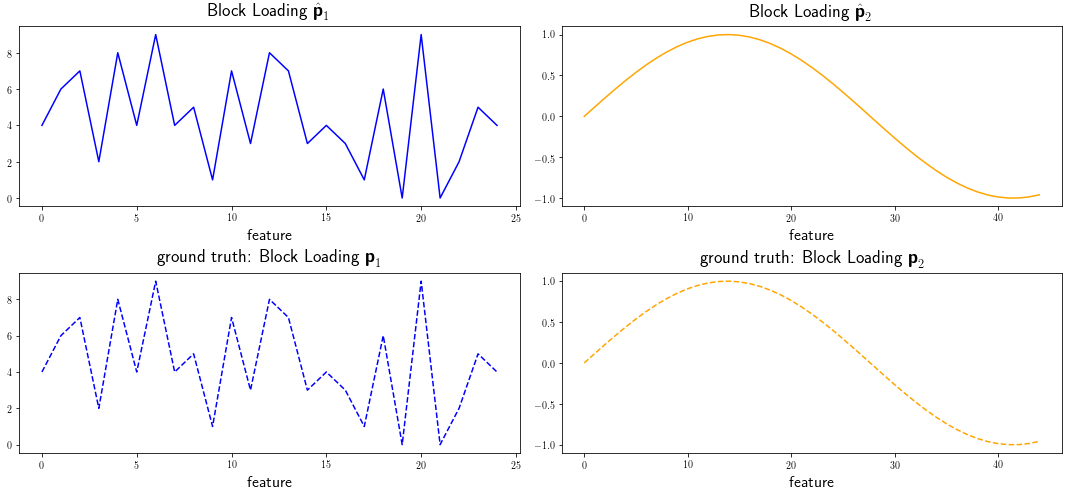

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,7))
ax[0][0].plot(p1_hat, color='blue') 
ax[0][0].set_title(r'Block Loading $\hat{\textbf{p}}_1$', size=18) 
ax[0][0].set_xlabel('feature', size=16)
ax[0][1].plot(p2_hat, color='orange') 
ax[0][1].set_title(r'Block Loading $\hat{\textbf{p}}_2$', size=18) 
ax[0][1].set_xlabel('feature', size=16)
ax[1][0].plot(p1,color='blue',ls='--') 
ax[1][0].set_title(r'ground truth: Block Loading $\textbf{p}_1$', size=18) 
ax[1][0].set_xlabel('feature', size=16)
ax[1][1].plot(p2,color='orange',ls='--') 
ax[1][1].set_title(r'ground truth: Block Loading $\textbf{p}_2$', size=18)
ax[1][1].set_xlabel('feature', size=16)
plt.tight_layout()

As you can see above the fitted block loadings $\hat{\textbf{p}}_1$ and $\hat{\textbf{p}}_2$ describe our original feature loadings perfectly. Depending on the initialization of the analysis the sign of the loading vectors might switch.

## Block scores $\hat{\textbf{t}}_1$ in LV1 and $\hat{\textbf{t}}_2$ in LV2 are highly correlated to ground truth $\textbf{t}_1$ and $\textbf{t}_2$

In [12]:
t1_hat = mbpls_model.T_[0][:,0]
t2_hat = mbpls_model.T_[1][:,1]
#t1_hat = mbpls_model.Ts_[:,0]
#t2_hat = mbpls_model.Ts_[:,1]

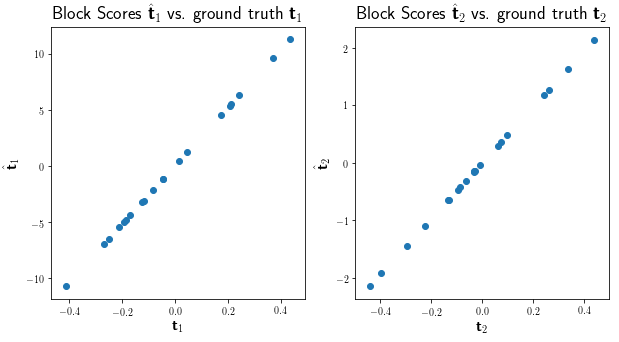

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(t1, t1_hat) 
ax[0].set_title(r'Block Scores $\hat{\textbf{t}}_1$ vs. ground truth $\textbf{t}_1$', fontsize=18)
ax[0].set_xlabel(r'$\textbf{t}_1$', size=15)
ax[0].set_ylabel(r'$\hat{\textbf{t}}_1$', size=15)
ax[1].scatter(t2, t2_hat)
ax[1].set_title(r'Block Scores $\hat{\textbf{t}}_2$ vs. ground truth $\textbf{t}_2$', fontsize=18)
ax[1].set_xlabel(r'$\textbf{t}_2$', size=15)
ax[1].set_ylabel(r'$\hat{\textbf{t}}_2$', size=15);

## Explained Variance and Block Importance

To show the importances and explained variance the MB-PLS model has detected, we extract these parameters from the fitted model.

In [14]:
variances_x = mbpls_model.explained_var_xblocks_
blockimportances = mbpls_model.A_
variance_y = mbpls_model.explained_var_y_

In [15]:
import pandas as pd
variances_x = pd.DataFrame(data=variances_x.T, columns=['expl. var. X1',
                                'expl. var. X2'], index=['LV1', 'LV2'])
variance_y = pd.DataFrame(data=variance_y, columns=['expl. var. Y'], 
                          index=['LV1', 'LV2'])
blockimportances = pd.DataFrame(data=blockimportances.T, columns=[
    'block importance X1', 'block importance X2'], index=['LV1', 'LV2'])
pd.concat((variances_x, blockimportances, variance_y), axis=1).round(3)

,expl. var. X1,expl. var. X2,block importance X1,block importance X2,expl. var. Y
LV1,1.0,0.0,1.0,0.0,0.5
LV2,0.0,1.0,0.0,1.0,0.5


As shown in the table above, the model perfectly fitted LV1 to describe block $\textbf{X}_1$. Accordingly, it describes correctly that the block importance for LV1 lies 100 % in the corresponding block $\textbf{X}_1$. Analogue to this, it correctly detected that block $\textbf{X}_2$ has 100% importance in LV2.

In [16]:
# This line is just to reset the latex formatting for the previous plots
matplotlib.rcdefaults()

## Using the custom plot function
However, this can be done much easier with the automatic custom visualization through the build in **plot** method of the **mbpls** package, which shows the main fitted attributes, i.e. scores, loadings, explained variance in $\textbf{Y}$ and block importances, of the fitted model by calling:

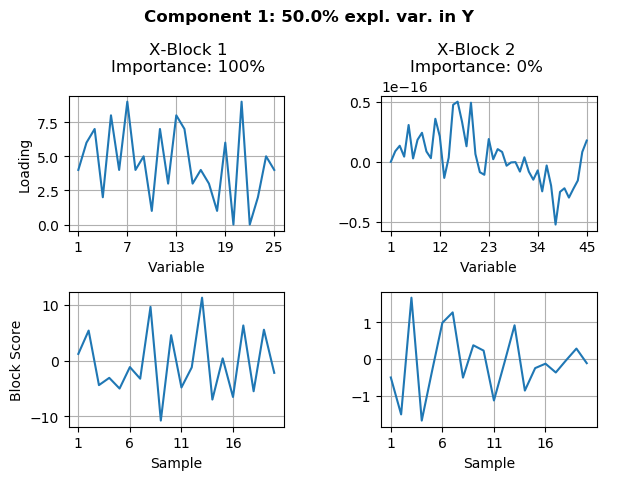

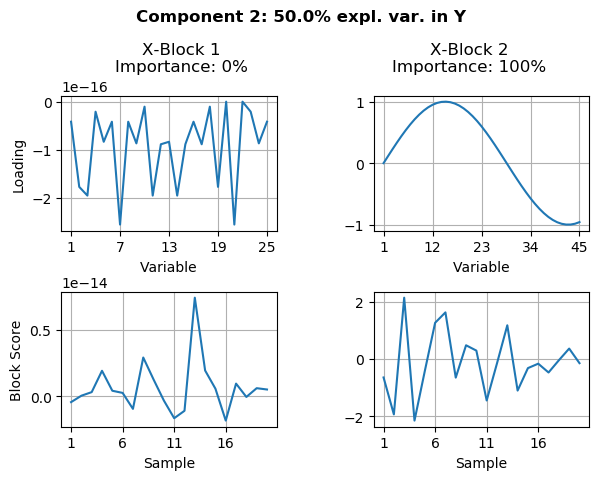

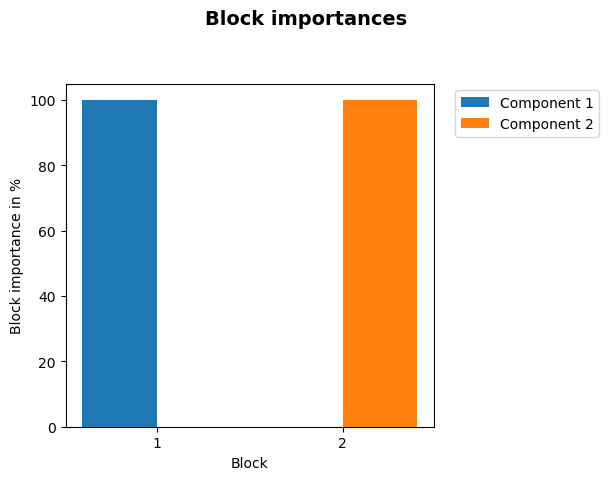

In [17]:
mbpls_model.plot(num_components=2)

*Note: In this artificial case the* **Block importance** *of both blocks is 0% for one of the respective components/LVs that they do not contribute to and thus there is only one bar for each block.*

## References

[1] J. A. Westerhuis, T. Kourti, and J. F. MacGregor, “Analysis of multiblock and hierarchical PCA and PLS models,” J. Chemom., vol. 12, no. 5, pp. 301–321, Sep. 1998.